In [2]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

# 動的なグラフを描画するライブラリ
import plotly.express as px

# sktimeで状態空間モデルを推定する
from sktime.forecasting.structural import UnobservedComponents

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [3]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [4]:
# 日単位データの読み込み
sales_day = pd.read_csv(
    "5-6-1-daily-sales-data.csv", index_col="date", parse_dates=True, dtype="float"
)
sales_day.index.freq = "D"

# 結果の確認
print(sales_day.head(3))
print(sales_day.tail(3))

                 sales  flyer
date                         
2000-01-01  462.387217    0.0
2000-01-02  363.262237    0.0
2000-01-03  356.648654    0.0
                 sales  flyer
date                         
2001-06-27  243.739643    0.0
2001-06-28  205.223214    0.0
2001-06-29  192.051090    0.0


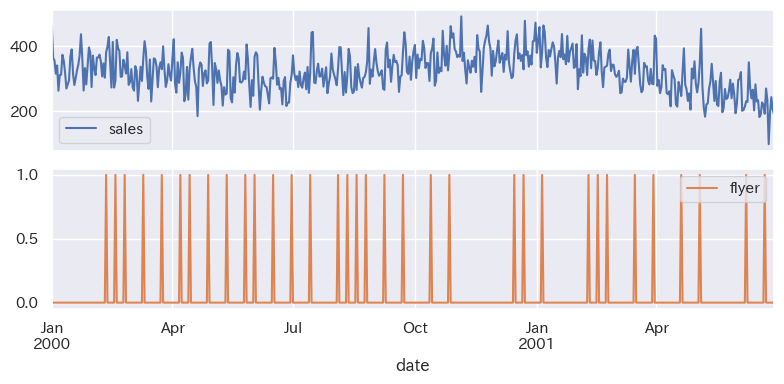

In [5]:
# 可視化
sales_day.plot(subplots=True)
plt.tight_layout()

In [6]:
# 参考：動的なグラフ
px.line(sales_day.sales)

In [7]:
# カレンダー情報を入れたデータ
sales_day_eda = sales_day.copy()

# 月
sales_day_eda["month"] = sales_day_eda.index.month

# 曜日
sales_day_eda["weekday"] = sales_day_eda.index.weekday

# 結果の確認
print(sales_day_eda.head(3))

                 sales  flyer  month  weekday
date                                         
2000-01-01  462.387217    0.0      1        5
2000-01-02  363.262237    0.0      1        6
2000-01-03  356.648654    0.0      1        0


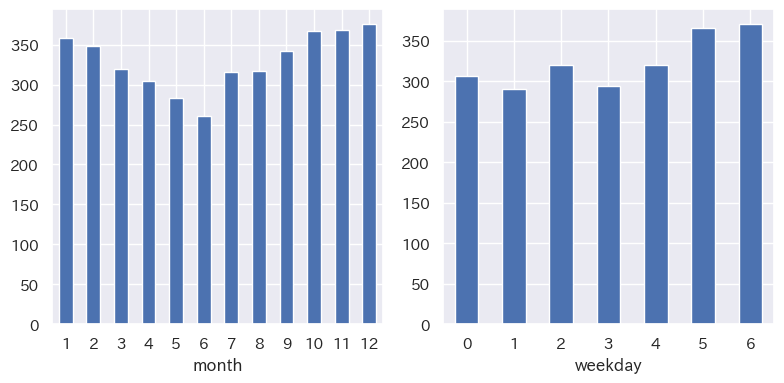

In [8]:
# 2列のグラフ
fig, ax = plt.subplots(ncols=2, tight_layout=True)

# 月ごとの売り上げ比較
sales_day_eda.groupby("month").mean()["sales"].plot(kind="bar", ax=ax[0])

# 曜日ごとの売り上げ比較
sales_day_eda.groupby("weekday").mean()["sales"].plot(kind="bar", ax=ax[1])

# X軸ラベルを回転させないようにする
ax[0].xaxis.set_tick_params(rotation=0)
ax[1].xaxis.set_tick_params(rotation=0)

In [9]:
# チラシの有無別売り上げ平均値
sales_day_eda.groupby("flyer").mean()["sales"]

flyer
0.0    324.384704
1.0    320.663946
Name: sales, dtype: float64

In [10]:
# ラグ特徴量の作成
# flyer_lag1: 1日前のチラシ配布（前日）
# flyer_lag2: 2日前のチラシ配布（前々日）
sales_day_eda["flyer_lag1"] = sales_day_eda["flyer"].shift(1).fillna(0)
sales_day_eda["flyer_lag2"] = sales_day_eda["flyer"].shift(2).fillna(0)

# 前日または前々日にチラシを配布した場合とそうでない場合で、
# 平均売上を比較する
print(sales_day_eda.groupby("flyer_lag1").mean()["sales"])
print(sales_day_eda.groupby("flyer_lag2").mean()["sales"])

flyer_lag1
0.0    319.717045
1.0    390.953406
Name: sales, dtype: float64
flyer_lag2
0.0    320.347595
1.0    381.458064
Name: sales, dtype: float64


In [11]:
# チラシをいつ配っているか
sales_day_eda.groupby("weekday").sum()["flyer"]

weekday
0     0.0
1     0.0
2     0.0
3     0.0
4    34.0
5     0.0
6     0.0
Name: flyer, dtype: float64

In [12]:
# ラグ特徴量を加える
# flyer_lag1: 1日前（前日）のチラシ配布有無
# flyer_lag2: 2日前（前々日）のチラシ配布有無
sales_day["flyer_lag1"] = sales_day["flyer"].shift(1).fillna(0)
sales_day["flyer_lag2"] = sales_day["flyer"].shift(2).fillna(0)

# 結果の確認
print(sales_day.loc["2000-02-17":"2000-02-21"])

                 sales  flyer  flyer_lag1  flyer_lag2
date                                                 
2000-02-17  273.073148    0.0         0.0         0.0
2000-02-18  295.044613    1.0         0.0         0.0
2000-02-19  419.312910    0.0         1.0         0.0
2000-02-20  393.584443    0.0         0.0         1.0
2000-02-21  385.480800    0.0         0.0         0.0


In [13]:
# 祝日を内閣府のWebサイトから読み込む
holiday = pd.read_csv(
    "https://www8.cao.go.jp/chosei/shukujitsu/syukujitsu.csv",
    encoding="CP932",  # 日本語（Shift_JIS）に対応する文字コード
    parse_dates=True,  # 日付をdatetime型に自動変換
    index_col=0,  # 日付列をインデックスとして扱う
)

# 結果の確認
print(holiday.head(3))

           国民の祝日・休日名称
国民の祝日・休日月日           
1955-01-01         元日
1955-01-15       成人の日
1955-03-21       春分の日


In [14]:
# 祝日フラグ
is_holiday = sales_day.index.isin(holiday.index).astype(int)

# 三が日と年末は祝日扱いにする
y_st = (sales_day.index.month == 1) & sales_day.index.day.isin([2, 3])
y_en = (sales_day.index.month == 12) & sales_day.index.day.isin([30, 31])
is_holiday = is_holiday + y_st + y_en

# データフレームにまとめる
sales_day["holiday"] = is_holiday

# 結果の確認
print(sales_day.head(3))

                 sales  flyer  flyer_lag1  flyer_lag2  holiday
date                                                          
2000-01-01  462.387217    0.0         0.0         0.0        1
2000-01-02  363.262237    0.0         0.0         0.0        1
2000-01-03  356.648654    0.0         0.0         0.0        1


In [15]:
# 日曜日かつ祝日の日は、通常の祝日と区別する
sales_day["sun_holiday"] = is_holiday & (sales_day.index.dayofweek == 6)

# 結果の確認
print(sales_day.head(3))

                 sales  flyer  flyer_lag1  flyer_lag2  holiday  sun_holiday
date                                                                       
2000-01-01  462.387217    0.0         0.0         0.0        1            0
2000-01-02  363.262237    0.0         0.0         0.0        1            1
2000-01-03  356.648654    0.0         0.0         0.0        1            0


In [16]:
# 季節変動ありの平滑化トレンドモデル
mod_bsts_1 = tsa.UnobservedComponents(
    sales_day["sales"],  # 対象データ
    level="smooth trend",  # 平滑化トレンド（local linear trendより滑らか）
    seasonal=7,  # 7日周期（週ごとの繰り返しを想定）
    exog=sales_day[
        [
            "holiday",
            "sun_holiday",  # 外生変数（イベント・販促効果）
            "flyer",
            "flyer_lag1",
            "flyer_lag2",
        ]
    ],
)

# 最尤法によるパラメータの推定
res_bsts_1 = mod_bsts_1.fit(
    method="nm",  # Nelder–Mead法による最適化（非線形パラメータ推定）
    maxiter=5000,  # 反復回数を増やし、収束を安定化
)

Optimization terminated successfully.
         Current function value: 4.954074
         Iterations: 1672
         Function evaluations: 2474


In [17]:
print(res_bsts_1.params)

sigma2.irregular    1237.337361
sigma2.trend           0.005019
sigma2.seasonal        0.001131
beta.holiday          54.939875
beta.sun_holiday     -89.121114
beta.flyer            -5.851354
beta.flyer_lag1       58.599129
beta.flyer_lag2       27.070706
dtype: float64


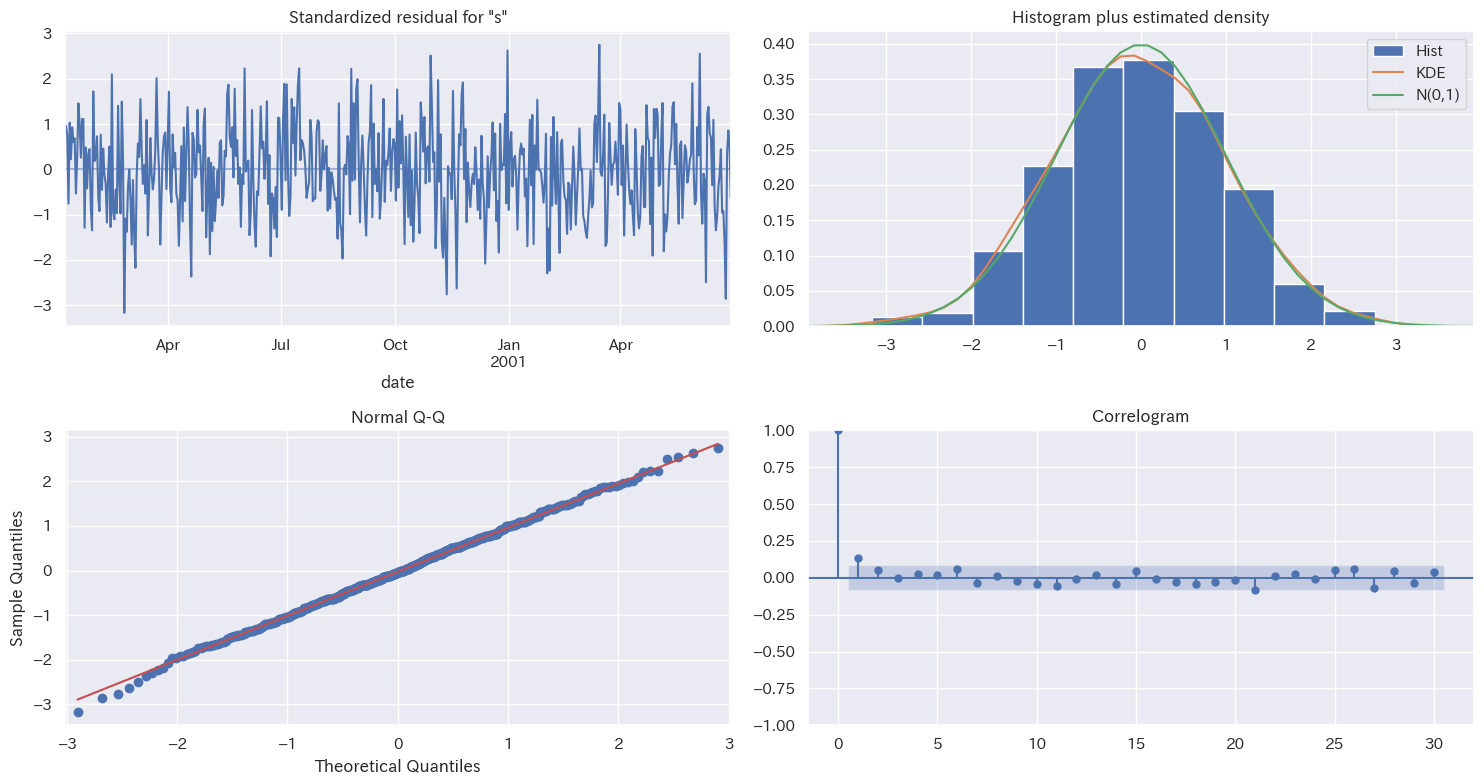

In [18]:
# 残差のチェック
_ = res_bsts_1.plot_diagnostics(
    lags=30, fig=plt.figure(tight_layout=True, figsize=(15, 8))
)

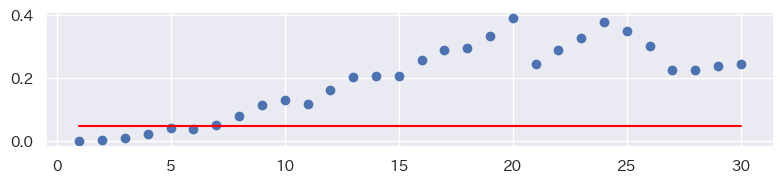

In [19]:
# 1時点前から30時点前まで、1つずつ最大次数をずらして、30回検定を行う
res_test = res_bsts_1.test_serial_correlation(method="ljungbox", lags=30)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# p値のグラフを描画
ax.scatter(np.arange(1, 31), res_test[0][1])

# 高さ0.05の位置に赤線を引く
ax.plot(np.arange(1, 31), np.tile(0.05, 30), color="red")

In [20]:
# ================================================
# 季節変動ありの平滑化トレンド（BSTS系）モデルの定義と推定
# --------------------------------
# 目的：
#   ・日次売上に見られる「週次の繰り返し」「年次パターン」「広告・祝日効果」
#     さらに「短期的な自己相関」を同時に表現する状態空間モデルを構築し、
#     カルマンフィルタ＋最尤法で推定する。
#
# モデルの理論（概略）：
#   観測方程式：
#       y_t = μ_t + γ_t^(7) + γ_t^(365) + u_t + x_t'β + ε_t
#     ここで、
#       μ_t        ：（滑らかな）トレンド（平滑化トレンド）
#       γ_t^(7)    ：週次季節成分（周期 7）
#       γ_t^(365)  ：年次季節成分（周期 365.25、三角関数近似＝トリゴナル季節）
#       u_t        ：残差の自己回帰（AR）構造（短期依存を吸収）
#       x_t'β      ：外生変数（祝日やチラシ配布の効果）
#       ε_t ~ N(0, σ_ε^2)：観測誤差
#
#   トレンドの状態方程式（平滑化トレンドの一例の書き方；直観）：
#       μ_t = μ_{t-1} + δ_{t-1} + η_t
#       δ_t = δ_{t-1} + ζ_t
#     （μ_t は水準、δ_t は傾き。η_t, ζ_t は互いに独立な正規雑音）
#     ※ statsmodels の "smooth trend" は、局所線形トレンドに近い
#       「滑らかな」ランダムウォーク的トレンドを表すオプション。
#
#   AR(2) 構造（観測誤差側の短期依存を吸収）：
#       u_t = φ1 u_{t-1} + φ2 u_{t-2} + e_t,  e_t ~ N(0, σ_e^2)
#
#   週次季節性（period=7）：
#       固定和制約（季節要因の和がゼロ）を持つ因子で表現（time-invariant constraints）。
#
#   年次季節性（freq_seasonal, period=365.25, harmonics=1）：
#       γ_t^(365) = a_1 sin(λ t) + b_1 cos(λ t)   （λ = 2π/365.25）
#     harmonics=1 は第1高調波のみ（年に1回の滑らかな波）。
#     harmonics を増やすとより複雑な周期形状を表せるが、過学習に注意。
#
#   推定：
#       ・内部ではカルマンフィルタ／カルマンスムーザーで状態を再帰推定
#       ・最尤法（ここでは Nelder–Mead）で分散や係数を推定
#
# 実務上の注意：
#   ・exog を標準化（スケーリング）すると収束が安定することが多い
#   ・季節と AR を同時に入れると同定が難しくなる場合があるため、
#     残差診断（自己相関・正規性）を必ず確認する
#   ・年次季節（365.25）は不規則な祝日と共存するため、両者の役割が混ざらないように
#     解釈に注意（祝日ダミーは鋭いスパイク、年次季節は滑らかな波として分担）
# ================================================

mod_bsts_2 = tsa.UnobservedComponents(
    # 観測データ（pd.Series）。ここでは日次売上を想定
    sales_day["sales"],
    # ---- トレンド：'smooth trend'
    # 局所線形トレンドに近い「滑らか」なランダムウォーク的トレンド。
    # レベルと傾きの両方を確率的に変動させ、緩やかな変化を表現。
    level="smooth trend",
    # ---- 週次季節：period=7
    # 1週間（7日）の繰り返しパターン。曜日効果のような挙動を吸収する。
    seasonal=7,
    # ---- 外生変数（祝日・年末年始・チラシ配布当日/ラグ効果）
    # β は最尤法で同時に推定される。
    exog=sales_day[["holiday", "sun_holiday", "flyer", "flyer_lag1", "flyer_lag2"]],
    # ---- 観測誤差側の AR 構造：短期自己相関を吸収
    # モデルの「不規則成分」の残差に AR(2) を付与し、短期依存を表現する。
    autoregressive=2,
    # ---- 年次季節（トリゴナル季節）：period=365.25, harmonics=1
    # sin/cos の第1高調波で年周期の滑らかな波形を追加。
    # （祝日ダミーなどの尖った効果と役割分担）
    freq_seasonal=[{"period": 365.25, "harmonics": 1}],
)

# ---- 最尤推定（MLE）
# ・method='nm' は Nelder–Mead。勾配を使わないためロバストだが遅め。
# ・maxiter を大きめに設定して収束性を担保。
# ・収束が不安定な場合は、初期値・スケーリング・bounds の設定を検討。
res_bsts_2 = mod_bsts_2.fit(method="nm", maxiter=5000)  # Nelder–Mead 法  # 最大反復回数

# （推奨）学習後の確認：
# 1) print(res_bsts_2.summary()) で推定パラメータ/分散の妥当性を確認
# 2) res_bsts_2.plot_diagnostics(lags=30) で残差の自己相関・正規性・定常性を確認
# 3) 週次・年次季節の寄与：res_bsts_2.seasonal  / トレンド：res_bsts_2.level を可視化
# 4) 予測は res_bsts_2.get_forecast(h).summary_frame() で点予測と区間（信頼区間）を取得

Optimization terminated successfully.
         Current function value: 4.926650
         Iterations: 4285
         Function evaluations: 5876


In [21]:
print(res_bsts_2.params)

sigma2.irregular                  628.416985
sigma2.trend                        0.000633
sigma2.seasonal                     0.000005
sigma2.freq_seasonal_365.25(1)      0.000005
sigma2.ar                         524.132668
ar.L1                               0.289602
ar.L2                              -0.081745
beta.holiday                       42.688372
beta.sun_holiday                  -39.619269
beta.flyer                         -4.793996
beta.flyer_lag1                    45.619286
beta.flyer_lag2                    22.602521
dtype: float64


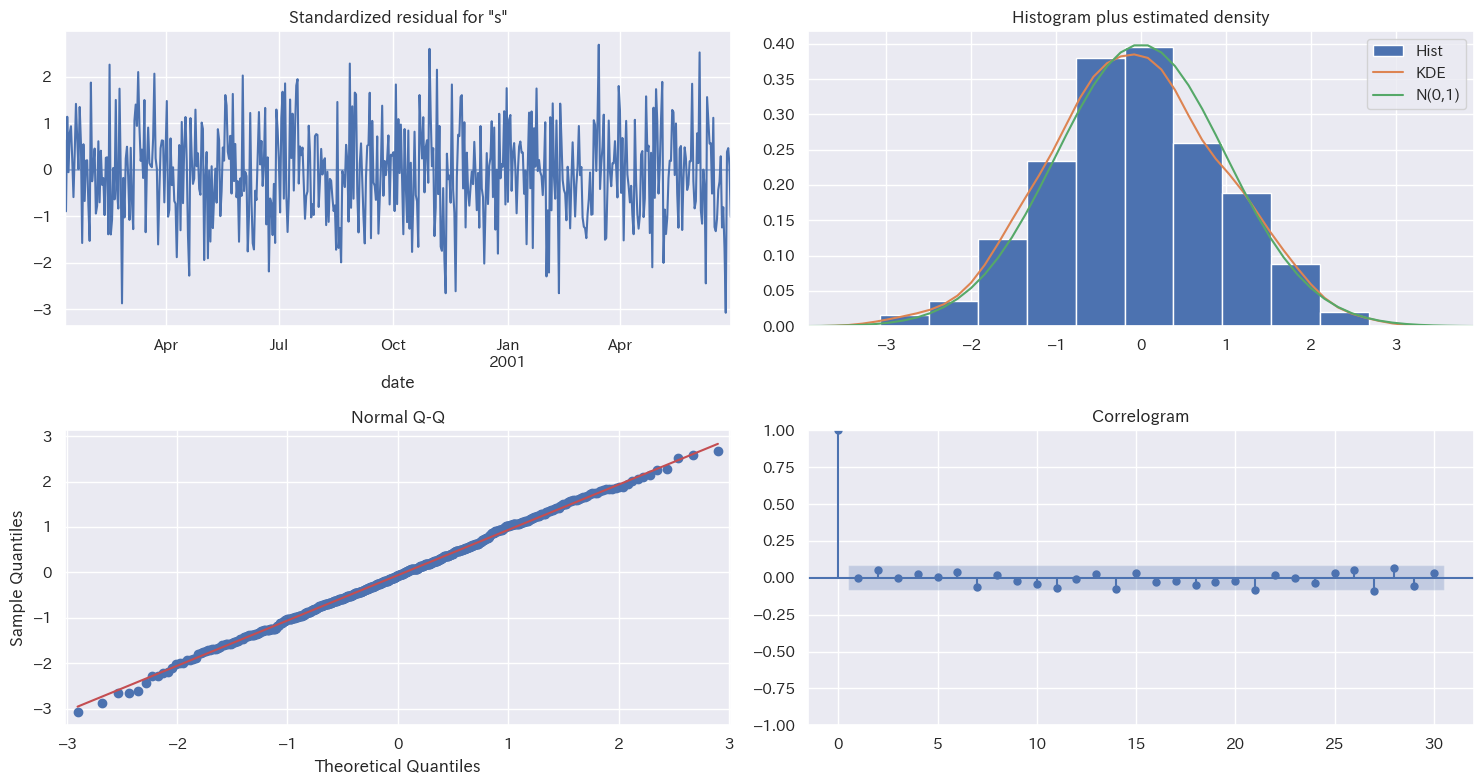

In [22]:
# 残差のチェック
_ = res_bsts_2.plot_diagnostics(
    lags=30, fig=plt.figure(tight_layout=True, figsize=(15, 8))
)

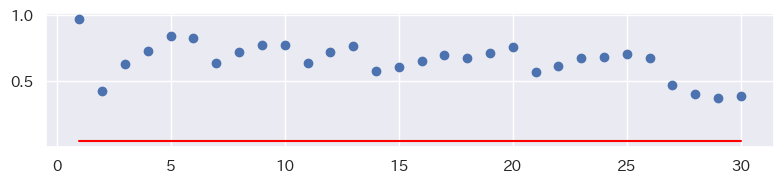

In [23]:
# 1時点前から30時点前まで、1つずつ最大次数をずらして、24回検定を行う
res_test = res_bsts_2.test_serial_correlation(method="ljungbox", lags=30)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# p値のグラフを描画
ax.scatter(np.arange(1, 31), res_test[0][1])

# 高さ0.05の位置に赤線を引く
ax.plot(np.arange(1, 31), np.tile(0.05, 30), color="red")

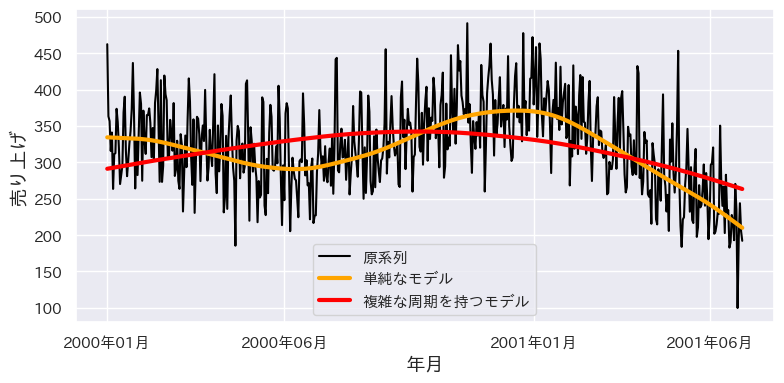

In [24]:
# ============================================================
# 2つのBSTSモデル（状態空間モデル）の平滑化水準成分の比較
# ============================================================

# ------------------------------------------------------------
# DataFrameにまとめる
# ------------------------------------------------------------
# 「sales」：実際の観測売上データ
# 「mod1_level」：単純モデル（週次季節＋トレンド）の平滑化トレンド成分
# 「mod2_level」：拡張モデル（週次＋年次季節＋AR＋外生変数）の平滑化トレンド成分
# ------------------------------------------------------------
plot_df = pd.DataFrame(
    {
        "sales": sales_day["sales"],
        "mod1_level": res_bsts_1.level["smoothed"],
        "mod2_level": res_bsts_2.level["smoothed"],
    }
)

# ------------------------------------------------------------
# 可視化処理
# ------------------------------------------------------------

# グラフサイズの指定（8×4インチ）
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)

# ------------------------------------------------------------
# 折れ線グラフの描画
# ------------------------------------------------------------
# 黒線：観測された生データ（原系列）
# オレンジ線：単純な平滑化トレンドモデルによる推定水準
# 赤線：自己回帰＋年周期を考慮した複雑モデルによる推定水準
# ------------------------------------------------------------
ax.plot(plot_df["sales"], color="black", label="原系列")
ax.plot(plot_df["mod1_level"], linewidth=3, color="orange", label="単純なモデル")
ax.plot(plot_df["mod2_level"], linewidth=3, color="red", label="複雑な周期を持つモデル")

# ------------------------------------------------------------
# 軸ラベルと凡例の設定
# ------------------------------------------------------------
ax.set_xlabel("年月", size=14)  # 横軸ラベル
ax.set_ylabel("売り上げ", size=14)  # 縦軸ラベル
ax.legend()  # 凡例の表示

# ------------------------------------------------------------
# X軸（年月）の表示設定
# ------------------------------------------------------------
# 半年ごとに主要目盛りを配置（1月と6月）
ax.xaxis.set_major_locator(mdates.MonthLocator([1, 6]))

# 目盛りのフォーマットを「YYYY年MM月」に設定
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y年%m月"))

# ------------------------------------------------------------
# 理論的背景（コメントとして）
# ------------------------------------------------------------
# ・BSTS（Bayesian Structural Time Series）や状態空間モデルにおける「水準成分」は、
#   時系列の基調的トレンド（long-term trend）を表す。
# ・`smooth trend` モデルはランダムウォーク的に変動するトレンドを仮定しており、
#   観測ノイズや短期変動を除去して滑らかな動きを抽出する。
# ・単純モデル（res_bsts_1）は週次季節のみを考慮しているため短期変動が残りやすい。
# ・複雑モデル（res_bsts_2）はAR(2)自己相関・年次周期・外生変数（チラシ・祝日）を含み、
#   より現実的かつ滑らかな基調変動を再現する。
# ・この比較により、モデル構造の拡張が平滑化トレンド推定に与える影響を可視化できる。

In [25]:
# ドリフト成分の比較
print("単純なモデルのドリフト成分", res_bsts_1.trend["smoothed"][-1])
print("複雑なモデルのドリフト成分", res_bsts_2.trend["smoothed"][-1])

単純なモデルのドリフト成分 -1.188799273630534
複雑なモデルのドリフト成分 -0.5139576984395505
